In [47]:
import torch
import e3nn
from minimal_basis.model.model_hamiltonian import generate_equi_rep_from_matrix
import matplotlib.pyplot as plt
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn.math import soft_one_hot_linspace

In [12]:
# Create an arbitrary atom with some atoms and bonds
num_nodes = 10
pos = torch.randn(num_nodes, 3)
max_radius = 1.8
row, col = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)
edge_vec = pos[row] - pos[col]
print(f"Number of atoms: {pos.shape[0]}")
print(f"Number of bonds: {row.shape[0]}")

Number of atoms: 10
Number of bonds: 22


In [37]:
# Create the node and edge feature matrices as an alias for the Hamiltonian 
# for the atomistic system
node_features_matrix = torch.randn(num_nodes, 2, 9, 9)
node_features_matrix_matrix = (node_features_matrix + node_features_matrix.transpose(3, 2)) / 2
edge_features_matrix = torch.randn(row.shape[0], 2, 9, 9)
edge_features_matrix = (edge_features_matrix + edge_features_matrix.transpose(3, 2)) / 2 

# Generate the representation fit for the model
node_features = generate_equi_rep_from_matrix(node_features_matrix)
edge_features = generate_equi_rep_from_matrix(edge_features_matrix)

# Irreps of the input are determined by construction
irreps_in = e3nn.o3.Irreps("1x0e+1x2e+1x4e+1x6e+1x8e")
irreps_out = e3nn.o3.Irreps("5x0e+4x1e+12x2e+10x3e+16x4e")
print(f"Dimensions of the input node features: {node_features.shape}")
print(f"Dimensions of the input edge features: {edge_features.shape}")
print(f"Dimension of the input irreps: {irreps_in.dim}")
print(f"Dimension of the output irreps: {irreps_out.dim}")

Dimensions of the input node features: torch.Size([10, 2, 45])
Dimensions of the input edge features: torch.Size([22, 2, 45])
Dimension of the input irreps: 45
Dimension of the output irreps: 291


For any random input graph, generate the output from a node ($f_i^\prime$) as,

$$
f_i^\prime = \sum_{\sigma=\{\uparrow, \downarrow\}}\frac{1}{\sqrt{z}} \sum_{j \in NN(i)} f_n^i \otimes h\left( ||x_{ij}|| \right) f_e^i
$$

In [14]:
# Start by analysing the TensorProduct that we need to carry out
tp = e3nn.o3.FullyConnectedTensorProduct(irreps_in, irreps_in, irreps_out, shared_weights=False)
print(f"Weights required by the tensor product: {tp.weight_numel}")

Weights required by the tensor product: 541


/Users/sudarshanvijay/miniconda3/envs/molml/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


Dimensions of the edge length embedding: torch.Size([22, 4])


Text(0.5, 0, 'Distance')

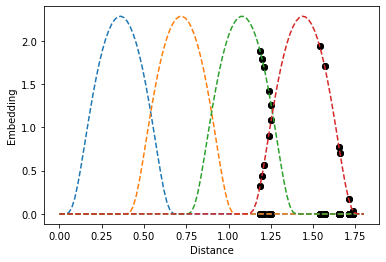

In [32]:
# Embed the distance between any two nodes into h
num_basis = 4
edge_length_embedding = soft_one_hot_linspace(
    edge_vec.norm(dim=1),
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)
edge_length_embedding = edge_length_embedding.mul(num_basis**0.5)
print(f"Dimensions of the edge length embedding: {edge_length_embedding.shape}")
plt.plot( edge_vec.norm(dim=1), edge_length_embedding.detach().numpy(), 'o', color='k')

# Plot a smooth version of the plot above
plt.plot( torch.linspace(0, max_radius, 100), soft_one_hot_linspace(
    torch.linspace(0, max_radius, 100),
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
).mul(num_basis**0.5).detach().numpy(), ls='--')
plt.ylabel("Embedding")
plt.xlabel("Distance")

In [34]:
# Create a Fully Connected Network
hidden_channels = 100
fc = e3nn.nn.FullyConnectedNet(
    [num_basis, hidden_channels, tp.weight_numel],
    torch.relu
)
weights_from_embedding = fc(edge_length_embedding)
print(f"Dimensions of the weights from the embedding: {weights_from_embedding.shape}")
print(f"Mean of the weights from the embedding: {weights_from_embedding.mean()}")
print(f"Standard deviation of the weights from the embedding: {weights_from_embedding.std()}")

Dimensions of the weights from the embedding: torch.Size([22, 541])
Mean of the weights from the embedding: 0.029150886461138725
Standard deviation of the weights from the embedding: 0.6254556775093079


In [46]:
# Take the tensor product between the nodes and features
print(f"Dimensions of the node features: {node_features[row].shape}")
print(f"Dimensions of the edge features: {edge_features.shape}")
print(f"Dimensions of the weights from the embedding: {weights_from_embedding.shape}")
summand_up = tp(node_features[row][:,0,:], edge_features[:,0,:], weights_from_embedding)
summand_down = tp(node_features[row][:,1,:], edge_features[:,1,:], weights_from_embedding)
print(f"Dimensions of the summand up: {summand_up.shape}")
print(f"Dimensions of the summand down: {summand_down.shape}")

Dimensions of the node features: torch.Size([22, 2, 45])
Dimensions of the edge features: torch.Size([22, 2, 45])
Dimensions of the weights from the embedding: torch.Size([22, 541])
Dimensions of the summand up: torch.Size([22, 291])
Dimensions of the summand down: torch.Size([22, 291])


In [50]:
# Scatter to the nearest neighbours
f_out_up = scatter(summand_up, col, dim=0, dim_size=num_nodes)
f_out_down = scatter(summand_down, col, dim=0, dim_size=num_nodes)
print(f"Dimensions of the output up: {f_out_up.shape}")
print(f"Dimensions of the output down: {f_out_down.shape}")

Dimensions of the output up: torch.Size([10, 291])
Dimensions of the output down: torch.Size([10, 291])
